# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import numpy as np
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, when, isnan, col, desc, udf, avg, row_number
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load

In [3]:
sparkify = 'mini_sparkify_event_data.json'
# path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(sparkify)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

### First impression

In [4]:
print('The dataset has {} rows and {} users.'.format(df.count(), df.select('userId').drop_duplicates().count()))

The dataset has 286500 rows and 226 users.


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
# lines per user
df.groupby('userId').count().orderBy(desc('count')).show(5)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
+------+-----+
only showing top 5 rows



### Summary statistics

In [8]:
df.describe(df.columns[:6]).show()

+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+



In [9]:
df.describe(df.columns[7:13]).show()

+-------+------+-----------------+------+-------+--------------------+-----------------+
|summary| level|         location|method|   page|        registration|        sessionId|
+-------+------+-----------------+------+-------+--------------------+-----------------+
|  count|286500|           278154|286500| 286500|              278154|           286500|
|   mean|  null|             null|  null|   null|1.535358834084427...|1041.526554973822|
| stddev|  null|             null|  null|   null| 3.291321616327586E9|726.7762634630741|
|    min|  free|       Albany, OR|   GET|  About|       1521380675000|                1|
|    max|  paid|Winston-Salem, NC|   PUT|Upgrade|       1543247354000|             2474|
+-------+------+-----------------+------+-------+--------------------+-----------------+



In [10]:
df.describe(df.columns[14:]).show()

+-------+------------------+--------------------+--------------------+-----------------+
|summary|            status|                  ts|           userAgent|           userId|
+-------+------------------+--------------------+--------------------+-----------------+
|  count|            286500|              286500|              278154|           286500|
|   mean|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+------------------+--------------------+--------------------+-----------------+



## Clean

### Invalid/missing data
#### no NaN or Null values in userID and sessionID

In [11]:
# inspired by https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe/44631639#44631639
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

#### ... but some empty strings in userID
Function 'describe' above shows there is no empty string in `sessionId` but at least one empty string in `userId` (min() is empty string).

Here: how often is the `userId` empty?:

In [12]:
df.filter(df.userId == '').count()

8346

... we notice the auth shows 'Logged Out' for those.

In [13]:
df.filter(df.userId == '').head(1)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId='')]

... and we find that __the userId is missing _only_ when the user is not logged in__:

In [14]:
df.filter((df.userId == '') & (df.auth != 'Logged In')).count()

8346

#### Remove lines w/o userId


In [15]:
lines_0 = df.count()

Define: filter using `userId != ''`.

Code:

In [16]:
df = df.filter(df.userId != '')

Test:

In [17]:
df.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [18]:
print('{:.0%} (count: {}) of the dataset rows are left.'.format(df.count() / lines_0, df.count()))

97% (count: 278154) of the dataset rows are left.


Those with most rows when logged in are assumed to be the most heavy users (empty strings are out):

In [19]:
df.groupBy('userId').count().sort(desc('count')).show(5)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
+------+-----+
only showing top 5 rows



### Check for NaN
NaN check above reveals: song, length, artist are missing the same number of rows & missing more than userId

In [20]:
print('{} lines are completely filled and there are {} lines where the "page" is "NextSong".'.format(
    df.dropna(how='any').count(),
    df.filter(~df.song.isNull()).groupBy('page').count().sort(desc('count')).select('count').collect()))

print('\n{:.0%} of the log entries are songs requested.'.format(df.dropna(how='any').count() / df.count()))

228108 lines are completely filled and there are [Row(count=228108)] lines where the "page" is "NextSong".

82% of the log entries are songs requested.


$\rightarrow$ song, length, artist are filled when the Sparkify user listens to songs. They are not filled e.g. for log entries "Add to Playlist", "Thumbs Up", etc.

$\rightarrow$ no issues with NaN values

In [21]:
# Entries w/o entry for song:
# df.filter(df.song.isNull()).groupBy('page').count().sort(desc('count')).show()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. 


#### Check how to identify churn

In [22]:
#df.select('page').dropDuplicates().sort('page').show()
cancel_event_count = df.where(df.page == 'Cancellation Confirmation').count()
account_count = df.select('userId').drop_duplicates().count()

print('There are {} cancellation events for {} accounts in the dataset (i.e. {:.0%} churn).'.format( 
    cancel_event_count, account_count, cancel_event_count / account_count))

There are 52 cancellation events for 225 accounts in the dataset (i.e. 23% churn).


$\rightarrow$ adequate churn share in data to train a model

#### Create churn column
__Define:__<br> 
Identify Churn as `df.page == 'Cancellation Confirmation'`. Create a column `Churn_user` which is 1 for a user with a cancellation confirmation.

__Code:__

In [23]:
# create flag churn
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# create churn column: mark event
df = df.withColumn('Churn', churn_event(df.page))

# create churn column: mark customer
users_churn = df.where(df.Churn == 1).select('userId').drop_duplicates().toPandas().values.tolist()
users_churn = list(np.concatenate(users_churn).flat)  
df = df.withColumn('Churn_user', when(col('userId').isin(users_churn), 1).otherwise(0))
print('{} users churned'.format(df.select('userId').filter(df.userId.isin(users_churn)).dropDuplicates().count()))

52 users churned


#### Test:

In [24]:
# column 'Churn' == 1 in cancellation row
df.select(['userId', 'firstName', 'ts', 'page', 'level', 'Churn']).where(df.userId == '125').sort('ts').collect() #9

[Row(userId='125', firstName='Mason', ts=1539317144000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317481000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317711000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317914000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318124000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318515000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318728000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318906000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318917000, page='Roll Advert', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318918000, page='Cancel', level='free', Churn=0),
 Row(userId='125', firstName=

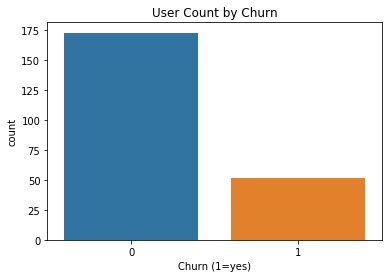

In [25]:
df_churn_pd = df.select(['userId', 'Churn_user']).drop_duplicates().groupBy('Churn_user').count().toPandas()
sb.barplot(y='count', x='Churn_user', data=df_churn_pd)
plt.title('User Count by Churn')
plt.xlabel('Churn (1=yes)');

In [26]:
#### As a bonus task, you can also look into the `Downgrade` events.
#= do not consider churn where a user cancels a paid subscription
#
### create flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
#
### create downgraded column
#df = df.withColumn('downgraded', flag_downgrade_event('page'))
#
### create flag free or paid phase
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
#df = df.withColumn('phase', Fsum('downgraded').over(windowval)) # phase: 1=paid before downgrade, 0=free 
#
##df.select(['userId', 'firstName', 'ts', 'page', 'level', 'phase']).where(df.userId == '30').sort('ts').collect() #9

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

As one approach we divide into users who cancel the usage. This is possible for both paid and free users.

#### Songs per User ... first impression, and then the next step: consider time scaling (e.g. per day) 
Those who cancel the service did use it considerably on average.

In [27]:
songs_by_churn = df.filter(df.page == 'NextSong').groupby(df.Churn_user).count().orderBy(df.Churn_user).toPandas()['count']
count_by_churn = df.groupBy('Churn').count().orderBy('Churn').toPandas()['count']
print('Songs by churn:\n', songs_by_churn, 
      '\n\nSongs per User by Churn:\n', songs_by_churn / count_by_churn)

Songs by churn:
 0    191714
1     36394
Name: count, dtype: int64 

Songs per User by Churn:
 0      0.689366
1    699.884615
Name: count, dtype: float64


Most heavy users of those who cancel:

In [28]:
df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy(desc('count')).show(1)

+------+-----+
|userId|count|
+------+-----+
|    29| 3028|
+------+-----+
only showing top 1 row



Least heavy users of those who cancel:

In [29]:
df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy('count').show(1)

+------+-----+
|userId|count|
+------+-----+
|   125|    8|
+------+-----+
only showing top 1 row



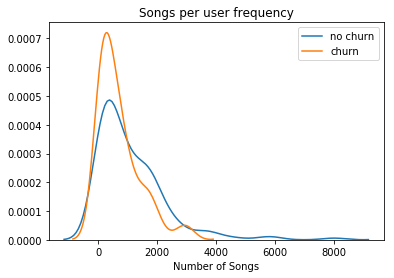

In [30]:
# plot distribution of songs per user listened
df_pd_0 = df.filter((df.page == 'NextSong') & (df.Churn_user == 0)).groupby('userId').count().toPandas()
df_pd_1 = df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().toPandas()

sb.distplot(df_pd_0['count'], hist=False, label='no churn')
sb.distplot(df_pd_1['count'], hist=False, label='churn')
plt.legend()
plt.title('Songs per user frequency')
plt.xlabel('Number of Songs');

$\rightarrow$ those who cancel typically listen to less songs in their lifetime $\rightarrow$ check below for the activity per time unit.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Songs Listened per User and Day

In [31]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn('day', get_day(df.ts))
#songs_in_day_overall = df.filter(df.page == 'NextSong').groupby(df.day).count().orderBy(df.day.cast('float'))

In [32]:
songs_in_day = df.filter(df.page == 'NextSong').groupby([df.userId, df.day]).count().orderBy(df.userId, df.day.cast('float'))
songs_in_day.show(2)
#df.groupBy('Churn_users').agg(count(col('day')).show())

+------+---+-----+
|userId|day|count|
+------+---+-----+
|    10|  3|   63|
|    10|  8|   57|
+------+---+-----+
only showing top 2 rows



#### Days listened & Songs per Day
__Define:__
aggregate to 1 row per userID to generate usual input for a non time-series model instead of multiple lines per user

Days listened = count the days where a user listened to songs


average of days where the user listened would be inappropriate (e.g. only listening on 30th of a month would be a higher value than listening every day

#### how many songs does the user listen to?
The song count per userId might be too skewed for users new to the service vs. not new

Therefore: average songs listened to on days where the service is used

__Code:__

In [33]:
songs_user = songs_in_day.groupby(['userId']).agg(count(col('day')), 
                                                  avg(col('count'))).orderBy('userId')
songs_user = songs_user.select(col('userId'), 
                               col('count(day)').alias('days_listened'), 
                               col('avg(count)').alias('songs_per_day'))

__Test:__

In [34]:
songs_user.show(3)

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    10|            7|96.14285714285714|
|   100|           25|           107.28|
|100001|            2|             66.5|
+------+-------------+-----------------+
only showing top 3 rows



In [35]:
# cross-check with separately doing a single aggreagation -> fine
songs_user_test = songs_in_day.groupby(['userId']).agg(avg(col('count'))).orderBy('userId')
#songs_user = songs_user.select(col('userId'), col('count(day)').alias('days_listened'))
songs_user_test.first()

Row(userId='10', avg(count)=96.14285714285714)

In [36]:
# cross-check for a heavy user identified above listening to a lot of songs
songs_user.where(songs_user.userId == 39).show() # listens on all days

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    39|           31|258.1290322580645|
+------+-------------+-----------------+



### combine data: label churn and static user features

#### Define:
The logfile stored in `df` has multiple rows per UserId. For any user there are static columns, i.e. which always contain the same information. Examples are `gender` and whether the user churned, i.e. `Churn_user`.

Extract static features from `df`. Join it with the metrics calculated above, i.e. `songs_user`.

#### Code

In [37]:
# first row for each user
# inspired by https://sparkbyexamples.com/spark/spark-dataframe-how-to-select-the-first-row-of-each-group/
df_by_user = df.withColumn('row', row_number().over(Window.partitionBy('userId').orderBy('userId'))).where(col('row') == 1)

# reduce columns
df_by_user = df_by_user.select(['userId', 'Churn_user', 'gender'])

# join with songs_user
df_model = df_by_user.join(songs_user, on=['userId']).orderBy('userId')

#### Test

In [38]:
print('1 row per unique userId:', 
      df_by_user.count() == df.select('userId').drop_duplicates().count())

1 row per unique userId: True


In [39]:
df_model.show(3)

+------+----------+------+-------------+-----------------+
|userId|Churn_user|gender|days_listened|    songs_per_day|
+------+----------+------+-------------+-----------------+
|    10|         0|     M|            7|96.14285714285714|
|   100|         0|     M|           25|           107.28|
|100001|         1|     F|            2|             66.5|
+------+----------+------+-------------+-----------------+
only showing top 3 rows



#### who Churn listens on less days and less songs per day
holds on average and looking at the distribution; the distribution for engangement is more clearly unimodal than for songs listened per day

In [40]:
df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').show()

+----------+------------------+
|Churn_user|avg(days_listened)|
+----------+------------------+
|         0|12.109826589595375|
|         1| 8.846153846153847|
+----------+------------------+



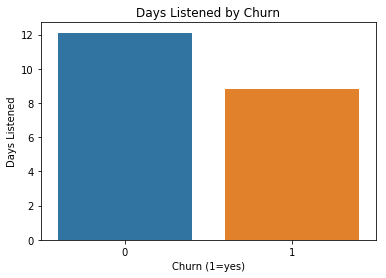

In [41]:
df_model_pd = df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').toPandas()
sb.barplot(x='Churn_user', y='avg(days_listened)', data=df_model_pd)
plt.title('Days Listened by Churn')
plt.xlabel('Churn (1=yes)')
plt.ylabel('Days Listened');

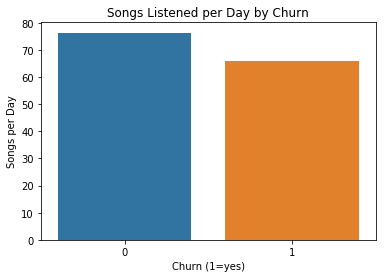

In [42]:
df_model_pd = df_model.groupby('Churn_user').agg(avg(col('songs_per_day'))).orderBy('Churn_user').toPandas()
sb.barplot(x='Churn_user', y='avg(songs_per_day)', data=df_model_pd)
plt.title('Songs Listened per Day by Churn')
plt.xlabel('Churn (1=yes)')
plt.ylabel('Songs per Day');

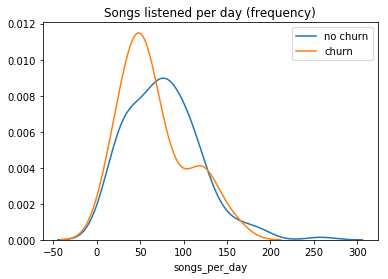

In [43]:
# plot distribution of songs per user & day listened
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('songs_per_day').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('songs_per_day').toPandas()

sb.distplot(df_pd_0.songs_per_day, hist=False, label='no churn')
sb.distplot(df_pd_1.songs_per_day, hist=False, label='churn')
plt.legend()
plt.title('Songs listened per day (frequency)');

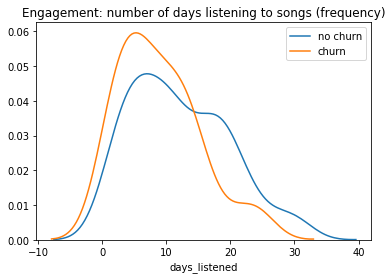

In [44]:
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('days_listened').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('days_listened').toPandas()

sb.distplot(df_pd_0.days_listened, hist=False, label='no churn')
sb.distplot(df_pd_1.days_listened, hist=False, label='churn')
plt.legend()
plt.title('Engagement: number of days listening to songs (frequency)');

#### ... by hour

In [45]:
# delete:
# by hour:

## udf = user-defined function
#get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour) 
#
## create column
#df = df.withColumn('hour', get_hour(user_log.ts)) # add 'hour' to dataframe
## df.head() 
#
## count next song page request by hour
#songs_in_hour = df.filter(df.page == 'NextSong').groupby(df.hour).count().orderBy(df.hour.cast('float'))
#songs_in_hour.show()
#
## visualize: transform to pandas
#songs_in_hour_pd = songs_in_hour.toPandas()
#plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
#plt.xlim(-1, 24);

In [46]:
### create flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
#
### create downgraded column
#user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))
#user_log_valid.head()
#
### create flag free or paid phase
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0) # thinkof partition as groupBy; look at all preceeding rows but no following rows
#user_log_valid = user_log_valid.withColumn('phase', Fsum('downgraded').over(windowval))
#user_log_valid.select(['userId', 'firstName', 'ts', 'page', 'level', 'phase']).where(user_log.userId == '1138').sort('ts').collect()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Deciding on the best approach: 
1. two-step optimization: a) obtain performance metrics for different estimators, choose the best, b) search the optimal parameter for the model from (a) with a grid or randomized search crossvalidation
2. one-step optimization: try different estimators based on parameter optimization for all of the models

$\rightarrow Approach (1) might not identify the best model as the performance boost from (1b) might be higher for a model weaker at first.

In [47]:
# rename target column
# using standards 'label' and 'features' as describedin docs: https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forests
df_model = df_model.withColumnRenamed('Churn_user', 'label')

# train-test split
train, non_train = df_model.randomSplit([.6, .4], seed=42)
test, validate = non_train.randomSplit([.5, .5], seed=42)
print('Precise split of all rows:', df_model.count() == train.count() + test.count() + validate.count())

# number of records
print('rows -- total: {}, train: {}, test: {}, and validation: {}'.format(
    df_model.count(), train.count(), test.count(), validate.count()))

Precise split of all rows: True
rows -- total: 225, train: 142, test: 15, and validation: 68


In [48]:
df_model.show(1)

+------+-----+------+-------------+-----------------+
|userId|label|gender|days_listened|    songs_per_day|
+------+-----+------+-------------+-----------------+
|    10|    0|     M|            7|96.14285714285714|
+------+-----+------+-------------+-----------------+
only showing top 1 row



In [49]:
train.show(3)#, col())

+------+-----+------+-------------+-------------+
|userId|label|gender|days_listened|songs_per_day|
+------+-----+------+-------------+-------------+
|   125|    1|     M|            1|          8.0|
|   124|    0|     F|           25|       163.16|
|     7|    0|     M|            8|        18.75|
+------+-----+------+-------------+-------------+
only showing top 3 rows



In [50]:
# build pipeline: use pipeline to prevent leaking knowledge from validation/test set
indexer = StringIndexer(inputCol='gender', outputCol='d_female')
assembler = VectorAssembler(inputCols=['days_listened', 'songs_per_day', 'd_female'], outputCol='features_unscaled')
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', withMean=True)

lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
rf = RandomForestClassifier(seed=42)
estimator_list = [lr, rf]


In [51]:
counter = 1
for estimator in estimator_list: # loop and how to obtain the algorithm name inspired by https://github.com/stephanieirvine/Udacity-Data-Scientist-Nanodegree/blob/main/Project%204/Sparkify.ipynb
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    start = time.time()
    model = pipeline.fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    print('... ran {} min and yields:'.format(round((time.time() - start) / 60, 1)))
    print('f1: {}, and accuracy: {}'.format(
        round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2),
        round(evaluator.evaluate(result, {evaluator.metricName: 'accuracy'}), 2)))

1/2: LogisticRegression
... ran 1.6 min and yields:
f1: 0.62, and accuracy: 0.73
2/2: RandomForestClassifier
... ran 1.6 min and yields:
f1: 0.59, and accuracy: 0.67


In [52]:
# combine with gridsearch
counter = 1
for estimator in estimator_list: # loop and how to obtain the algorithm name inspired by https://github.com/stephanieirvine/Udacity-Data-Scientist-Nanodegree/blob/main/Project%204/Sparkify.ipynb
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.num_trees, [50, 100])
        .addGrid(rf.depth,[2,10]) \ # rf.criterion,['gini','entropy']
        .build()
        
    start = time.time()
    model = ....fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    print('... ran {} min and yields:'.format(round((time.time() - start) / 60, 1)))
    print('f1: {}, and accuracy: {}'.format(
        round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2),
        round(evaluator.evaluate(result, {evaluator.metricName: 'accuracy'}), 2)))

IndentationError: unexpected indent (<ipython-input-52-b9dfa34eeda4>, line 9)

In [ ]:
# https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
num_trees =  random.choice(list(range(50,500)))
depth = random.choice(list(range(2,10)))
criterion = random.choice(['gini','entropy'])

In [ ]:
# rf
paramGrid = ParamGridBuilder() \
    .addGrid(rf.num_trees, [50, 100])
    .addGrid(rf.depth,[2,10]) \ # rf.criterion,['gini','entropy']
    .build()

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3) # parallelism=2

In [ ]:
# lr
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3) # parallelism=2

In [ ]:
print(rf.explainParams())

In [ ]:
correct_prediction_count, rows = result.filter(result.label == result.prediction).count(), result.count()
print('accuracy for last estimator: {:.0%} ({} / {})'.format(
    correct_prediction_count / rows, correct_prediction_count, rows))

In [ ]:
result.select(['userId', 'label', 'prediction']).orderBy('userId').show(30)

In [ ]:
# use?: # data = df.select(col("NumTags").alias("label"), col("DescVec").alias("features"))
cvModel = crossval.fit(train)
result = cvModel.transform(test)

In [ ]:
#paramGrid.size

In [ ]:
cvModel.avgMetrics


In [ ]:
result.show()

In [ ]:
result.select(col('prediction')).show(10)

In [ ]:
#df_model.groupby('Churn_user').agg(avg(col('songs_per_day'))).orderBy('Churn_user').show()

result.groupby('prediction').count().show()

In [ ]:


# bestModel = None

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
# compare against:
# https://github.com/stephanieirvine/Udacity-Data-Scientist-Nanodegree/blob/main/Project%204/Sparkify.ipynb
# blog: https://medium.com/swlh/predicting-churn-with-pyspark-4c8edc8a19e0

# https://towardsdatascience.com/predicting-customer-churn-using-pyspark-6a78a78a8412